In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 99% 1.05G/1.06G [00:13<00:00, 101MB/s]
100% 1.06G/1.06G [00:14<00:00, 81.5MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

import cv2
import os
import random
import numpy as np

**Generator**: https://keras.io/api/data_loading/image/

In [12]:
# generators -> very useful for large amount of data
train_ds = keras.utils.image_dataset_from_directory(
    directory = '//content/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


We stored the file numpy array and value is (0 - 255) but we have to store value (0 - 1). So, we use normalize.

### **Why using normalize?**
pixel value lie between 0 to 1 -> good accuracy


In [13]:
# normalize
def process(image, label):
  image = tf.cast(image/255. ,tf.float32)
  return image, label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [15]:
# create CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3),padding='valid', input_shape=(256, 256, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, padding = 'valid'))

model.add(Conv2D(64, kernel_size = (3, 3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, padding = 'valid'))

model.add(Conv2D(128, kernel_size = (3, 3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, padding = 'valid'))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [18]:
history = model.fit(train_ds, epochs = 10, validation_data = validation_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.5625 - loss: 2.8726 - val_accuracy: 0.6602 - val_loss: 0.6123
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 83ms/step - accuracy: 0.6694 - loss: 0.6223 - val_accuracy: 0.6896 - val_loss: 0.6050
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 84ms/step - accuracy: 0.7339 - loss: 0.5255 - val_accuracy: 0.6680 - val_loss: 0.6353
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.7869 - loss: 0.4584 - val_accuracy: 0.8046 - val_loss: 0.4248
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.8213 - loss: 0.4032 - val_accuracy: 0.7590 - val_loss: 0.4895
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 80ms/step - accuracy: 0.8515 - loss: 0.3393 - val_accuracy: 0.8210 - val_loss: 0.4229
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.8924 - loss: 0.2477 - val_accuracy: 0.8028 - val_loss: 0.5965
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - accuracy: 0.9286 - loss: 0.1786 - 

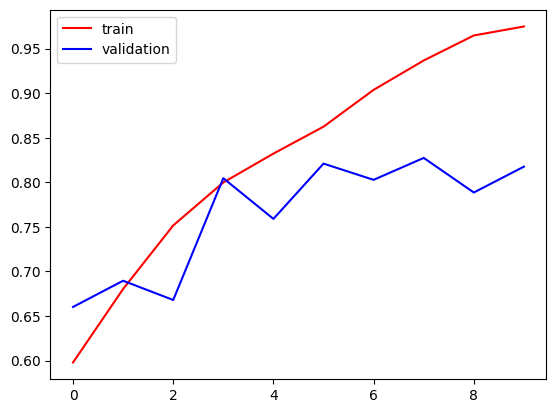

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

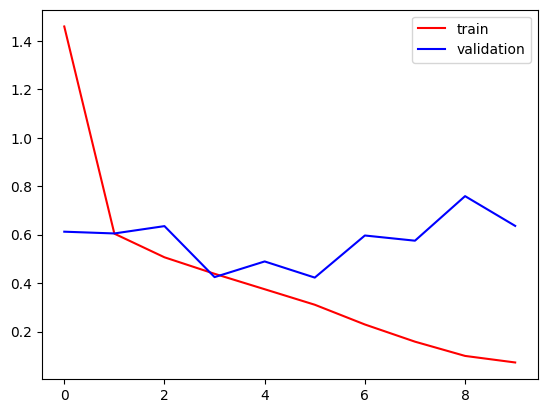

In [21]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

In [ ]:
import cv2

In [ ]:
test_img = cv2.imread('/content/dog.jpg')
test_img.shape

(480, 640, 3)

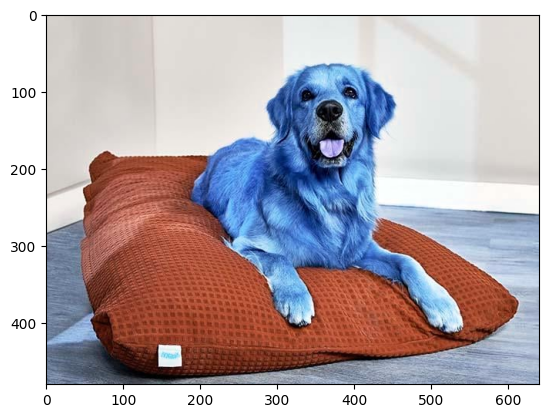

In [ ]:
plt.imshow(test_img)

In [ ]:
test_img = cv2.resize(test_img, (256, 256))
test_input = test_img.reshape((1, 256, 256, 3))

In [ ]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


array([[1.]], dtype=float32)

### **Data Augmentation**
for multiple image

In [22]:
import tensorflow
from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(rescale = 1./255)
# why we are not other changes on test data? - cause only train model on multiple images for better test

train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size = (150, 150),
    batch_size = batch_size,
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
    '/content/test',
    target_size = (150, 150),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [29]:
# create CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3),padding='valid', input_shape=(150, 150, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, padding = 'valid'))

model.add(Conv2D(64, kernel_size = (3, 3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, padding = 'valid'))

model.add(Conv2D(128, kernel_size = (3, 3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, padding = 'valid'))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### **Original images are not using -> transformation images are using for train model**

In [32]:
history = model.fit(
    train_generator,
    steps_per_epoch = 2000 // batch_size,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps = 800 // batch_size
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - accuracy: 0.6979 - loss: 0.5604 - val_accuracy: 0.7350 - val_loss: 0.5406
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.6965 - loss: 0.5808 - val_accuracy: 0.6775 - val_loss: 0.5949
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.7214 - loss: 0.5638 - val_accuracy: 0.5038 - val_loss: 0.8507
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.6925 - loss: 0.5610 - val_accuracy: 0.7088 - val_loss: 0.5812
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.7292 - loss: 0.5333 - val_accuracy: 0.6650 - val_loss: 0.6700
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - accuracy: 0.7322 - loss: 0.5478 - val_accuracy: 0.6913 - val_loss: 0.5627
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.7436 - loss: 0.5382 - val_accuracy: 0.7050 - val_loss: 0.5233
Epoch 8/10
  1/125 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.7500 - loss: 0

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.7459 - loss: 0.5086 - val_accuracy: 0.7125 - val_loss: 0.5432
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.7378 - loss: 0.5097 - val_accuracy: 0.7475 - val_loss: 0.4963
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.7733 - loss: 0.5041 - val_accuracy: 0.6650 - val_loss: 0.6160
